In [7]:
import os
import numpy as np
from datasets import load_dataset, Audio
from transformers import AutoModelForAudioClassification, AutoFeatureExtractor, TrainingArguments, Trainer
import evaluate
import time
from sklearn.metrics import confusion_matrix, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import psutil
import GPUtil
import time
import threading

In [8]:
max_cpu_usage = 0
max_ram_usage = 0
max_gpu_usage = 0

def monitor_resources():
    global max_cpu_usage, max_ram_usage, max_gpu_usage
    while True:
        cpu_usage = psutil.cpu_percent(interval=0.5)
        ram_usage = psutil.virtual_memory().used / (1024 ** 2)  # Convertir en MB
        max_cpu_usage = max(max_cpu_usage, cpu_usage)
        max_ram_usage = max(max_ram_usage, ram_usage)

        gpus = GPUtil.getGPUs()
        gpu_usage = max([gpu.load * 100 for gpu in gpus]) if gpus else 0
        max_gpu_usage = max(max_gpu_usage, gpu_usage)

        time.sleep(1)

monitor_thread = threading.Thread(target=monitor_resources, daemon=True)
monitor_thread.start()

In [9]:
gtzan = load_dataset("marsyas/gtzan", "all")
gtzan = gtzan["train"].train_test_split(seed=42, shuffle=True, test_size=0.1)
id2label_fn = gtzan["train"].features["genre"].int2str

README.md:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

gtzan.py:   0%|          | 0.00/3.35k [00:00<?, ?B/s]

The repository for marsyas/gtzan contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/marsyas/gtzan.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


genres.tar.gz:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [10]:
model_id = "ntu-spml/distilhubert"
feature_extractor = AutoFeatureExtractor.from_pretrained(
    model_id, do_normalize=True, return_attention_mask=True
)

preprocessor_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

In [11]:
sampling_rate = feature_extractor.sampling_rate
gtzan = gtzan.cast_column("audio", Audio(sampling_rate=sampling_rate))

In [12]:
def preprocess_function(examples, max_duration = 30.0):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

In [13]:
gtzan_encoded = gtzan.map(
    preprocess_function,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=100,
    num_proc=1,
)
gtzan_encoded = gtzan_encoded.rename_column("genre", "label")
id2label = {
    str(i): id2label_fn(i)
    for i in range(len(gtzan_encoded["train"].features["label"].names))
}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

Map:   0%|          | 0/899 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [14]:
os.environ["WANDB_DISABLED"] = "true"

In [15]:
model = AutoModelForAudioClassification.from_pretrained(
    model_id,
    num_labels=num_labels,
    label2id=label2id,
    id2label=id2label,
)

config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/94.0M [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [17]:
model_name = model_id.split("/")[-1]
batch_size = 8
gradient_accumulation_steps = 1
num_train_epochs = 15

training_args = TrainingArguments(
    f"{model_name}-finetuned-gtzan",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    warmup_ratio=0.1,
    logging_steps=5,
    load_best_model_at_end=True,
    report_to=None,  # Disable W&B reporting
    metric_for_best_model="accuracy",
    fp16=True,
    push_to_hub=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [18]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=gtzan_encoded["train"],
    eval_dataset=gtzan_encoded["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)

<ipython-input-18-bf649dca5b61>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
start_time = time.time()

trainer.train()

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds")

Epoch,Training Loss,Validation Loss,Accuracy
1,2.077900,1.980664,0.460000
2,1.294600,1.298320,0.650000
3,1.039700,0.999747,0.730000
4,0.602800,0.711926,0.780000
5,0.572400,0.639471,0.800000
6,0.285000,0.594108,0.800000
7,0.229500,0.489865,0.850000
8,0.074200,0.652908,0.820000
9,0.061100,0.531993,0.830000
10,0.032600,0.578287,0.840000


Training completed in 8012.88 seconds


In [20]:
trainer.save_model("./fine_tuned_model")


 Classification Report:
               precision    recall  f1-score   support

       blues       0.89      0.80      0.84        10
   classical       1.00      1.00      1.00         9
     country       0.56      0.62      0.59         8
       disco       0.75      1.00      0.86         6
      hiphop       0.93      1.00      0.96        13
        jazz       1.00      1.00      1.00         9
       metal       0.82      1.00      0.90        14
         pop       1.00      0.89      0.94         9
      reggae       1.00      0.71      0.83         7
        rock       0.67      0.53      0.59        15

    accuracy                           0.85       100
   macro avg       0.86      0.86      0.85       100
weighted avg       0.85      0.85      0.85       100


 Temps d'inférence : 44.01 secondes


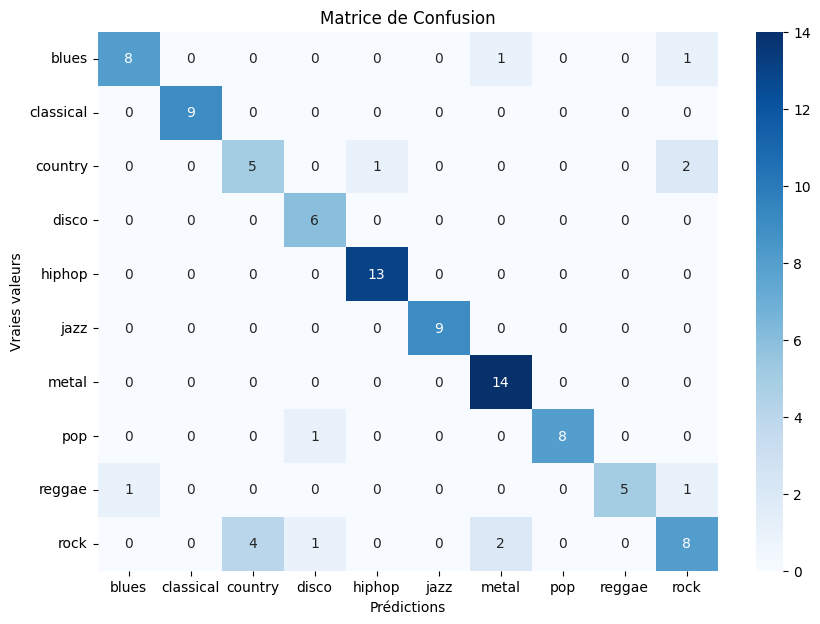

In [21]:
start_time = time.time()

predictions = trainer.predict(gtzan_encoded["test"])

end_time = time.time()
inference_time = end_time - start_time

y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

report = classification_report(y_true, y_pred, target_names=id2label.values())

print("\n Classification Report:\n", report)

print(f"\n Temps d'inférence : {inference_time:.2f} secondes")

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=id2label.values(), yticklabels=id2label.values())
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")
plt.show()

In [22]:
print(f"Utilisation maximale des ressources pendant l'exécution :")
print(f"CPU : {max_cpu_usage:.2f} %")
print(f"RAM : {max_ram_usage:.2f} MB")
print(f"GPU : {max_gpu_usage:.2f} %")

Utilisation maximale des ressources pendant l'exécution :
CPU : 66.20 %
RAM : 2948.91 MB
GPU : 100.00 %
